# CS-E5710 BAYESIAN DATA ANALYSIS - PROJECT
## Table of Content:
* [1. INTRODUCTION](#1)
* [2. DESCRIPTION OF DATA AND THE ANALYSIS PROBLEM](#2)
* [3. MODELS' DESCRIPTION](#3)
* [4. MODEL COMPARSION](#4)
* [5. PREDICTIVE PERFORMANCE ASSESSMENT](#5)
* [6. DISCUSSION AND POTENTIAL IMPROVEMENTS](#6)
* [7. CONCLUSION](#7)
* [8. SELF-REFLECTION LESSONS](#8)

## 1. INTRODUCTION<a class="anchor" id="1"></a>
Predicting one's heart condition is crucial for giving proper medical decisions and possibly saving lives. The misdiagnosis of heart disease may cause serious problems, as being left untreated adequately can even lead to an irreversible damage in the heart muscle and can be life-threatening. Therefore, the correct diagnosis of the heart disease status is extremely vital not only for patients’ health but also their live. Unfortunately, the heart disease status cannot be diagnosed easily since there are many blood vessels in the human body which lead directly to the heart and it is very expensive and time consuming to check all the blood vessels’ conditions by imaging method such as coronary angiogram. Hence, before making the decision whether or not conducting complicated examination techniques, it is important for the doctor to accurately assess the patients’ heart condition based on easily measurable biometric parameters such as age, sex, chest paint types, resting blood vessels, blood cholesterol levels, etc. In this project, we will try to build linear regression and logistic models that could be used to predict whether the patient has heart disease or not based on the medical record such as age, sex, resting blood vessels etc.

## 2. DESCRIPTION OF DATA AND THE ANALYSIS PROBLEM<a class="anchor" id="2"></a>

In [6]:
import pandas as pd

df = pd.read_csv('heart.csv')

### Normalizing numeric features value
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
col_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[col_to_scale] = SS.fit_transform(df[col_to_scale])
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.952197,1,3,0.763956,-0.256334,1,0,0.015443,0,1.087338,0,0,1,1
1,-1.915313,1,2,-0.092738,0.072199,0,1,1.633471,0,2.122573,0,0,2,1
2,-1.474158,0,1,-0.092738,-0.816773,0,0,0.977514,0,0.310912,2,0,2,1
3,0.180175,1,1,-0.663867,-0.198357,0,1,1.239897,0,-0.206705,2,0,2,1
4,0.290464,0,0,-0.663867,2.082050,0,1,0.583939,1,-0.379244,2,0,2,1


Our application can be modelled as Bayesian problem with **data points** representing patients who have already undergone heart tests. Each data point is characterized by 13 different health parameters such as age, sex, chest pain type, resting blood pressure, etc. Using all 13 different health parameters to compute the model may not be a good ideas for several reasons. First of all, using more features means more computing power and time. In addition, using all the features in the model may cause over-complicated of overfitting model. Hence, base on our medicine/biology knowledges, we picked out top 5 health parameters/indicators that we think the most relevant to the heart disease status. Below is the list of 5 parameters that we used:
- Chest pain type (**cp**): value 1 = typical angina, value 2 = atypical angina, value 3 = non-anginal pain, value 4 = asymptomatic. Choosing explanation:  When the patients has an abnormal servese and typical chest pain type then obviously their hearts don't work correctly and the chance to have a heart disease is higher
- Resting blood pressure (**trestbps**): measuring unit in mmHg. Choosing explanation: Ideal blood pressure is considered between 90/60 mmHg and 120/80 mmHg. High blood pressure is considered to be 140/90 mmHg or higher. High blood pressure is usually one of the indications for possible heart's disease.
- The patient's maxium heart rate achieved when exercise(**thalach**). Choosing explanation: similar to the resting blood pressure, if the thalach value is too high then it is also an indicators for heart's problem.
- Number of major vessels coloured by fluoroscopy (**ca**): value 0 to 4. Choosing explaination: human's heart has 4 major vessels. If any of 4 major vessels are blocked then that person has extremely high risk to have heart disease.
- ST depression induced by exercise relative to rest (**oldpeak**): The position of ST interval ECG plot. [S-T Segment]. Choosing explanation: Ideally the ST segment in an EKG graph is an straight line. However, if the ST segment is curve then that is a big red flag to show that the heart does not work correctly.

The quantity of interest/prediction of a data point is the heart disease status, for which values 0 and 1 indicate no presence and presence of a heart disease, respectively.
We gathered the data points with known label values using the patients’ health data recording available from UC Irvine machine learning heart disease repository which can be accessed via the link: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/

The above data repository contains health records data from 4 different locations such as Cleveland and Long Beach of America, Switzerland, and Hungary. However, only the Cleveland’s dataset is in a good condition and being maintained. All other datasets are in poor condition and do have a lot of missing information. Thus, we will use the Cleveland dataset which consists of 303 data points which are suitable for our project.

This list of all dataset's parameters' explanation in [Appendix A](#Appendix-A)

## 3. MODELS' DESCRIPTION<a class="anchor" id="3"></a>

### 3.1 Linear regression model

#### 3.1.1 Model theoratical/mathematic description
The multivariable linear regression model describes the relation of given parameters to the probability of detecting disease.

\begin{align}
    \theta_i = \alpha + \beta_1x_{1i} + \beta_2x_{2i} + ... + \beta_Jx_{Ji}
\end{align}

where
- $\theta_i$ is the probability of detecting disease
- $\alpha$ and $\beta_.$ is the intercept and scalar response parameters of $\beta{x}+\alpha$
- $J$ is the number of studied variables or number of dimensions from given data

Stan model embeds the necessary data normalization and linearly scales $x_.$ to range $[0;1]$.

#### 3.1.2. Priors choice explanation
Although the heart disease dataset was published long time ago, there is still limited amount of medical research using it and the researches study about the relation between the parameters such  ST depression induced by exercise relative to rest or maximum heart rate achieve to the heart disease status. Therefore, we think using the previous knowledge from other heart disease cases is almost imposible for use, instead we used weakly informative priors. We have tried out different priors options and checked out the accuracy of the model. At the end, we decided to choose beta distribution _ beta(1, 1) as a default prior for alpha and normal distribution _ normal(0, 1) as the default prior for beta.

#### 3.1.3. Model stan code

Below is the stan code for linear regression model


In [3]:
linear_regression = '''
data {
  int<lower=1> N;                           // number of data points
  int<lower=1> J;                           // number of dimensions
  matrix[N, J] x;                           // data
  real<lower=0, upper=1> y[N];              // outcomes
  real prior_alpha_mu;                      // prior mean for alpha
  real<lower=0> prior_alpha_sigma;          // prior std for alpha
  real prior_beta_mu;                       // prior mean for beta
  real<lower=0> prior_beta_sigma;           // prior std for beta
}
transformed data {
  vector[J] min_x;
  vector[J] scale_x;
  matrix<lower=0, upper=1>[N, J] x_std;
  for (j in 1:J) {
    min_x[j] = min(x[,j]);
    scale_x[j] = (max(x[,j]) - min_x[j]);
    x_std[,j] = (x[,j] - min_x[j]) / scale_x[j];
  }
}
parameters {
  real<lower=0, upper=1> alpha;
  vector[J] beta;
  real<lower=0> sigma;
}

model {
  sigma ~ cauchy(0,10);
  alpha ~ beta(1, 1);
  beta ~ normal(prior_beta_mu, prior_beta_sigma);
  y ~ normal(alpha + x_std * beta, sigma);
}
generated quantities {
  vector[N] log_lik;
  vector[N] probs;

  for (i in 1:N) {
    log_lik[i] = normal_lpdf(y | alpha + x_std[i] * beta, sigma);
    probs[i] = alpha + x_std[i] * beta;
  }
}
'''

Below is the code to build and sampling the model

In [2]:
%%capture --no-display

import inspect

import arviz as az
import nest_asyncio
import pandas as pd
from IPython.display import display, display_markdown

import linear_regression as lin

data = pd.read_csv('heart.csv')
samples = data[['cp', 'trestbps', 'thalach', 'ca', 'oldpeak']]
outcomes = data['target']

nest_asyncio.apply()
model = lin.build(samples, outcomes)
linear_fit = lin.sample(model)

Below is the visualisation of the linear correlation of disease probability and parameter values shown in red lines. Blue spots show the distribution of given data, jittered along the x-axis to improve readability. y-axis illustrates the estimated probability of disease.

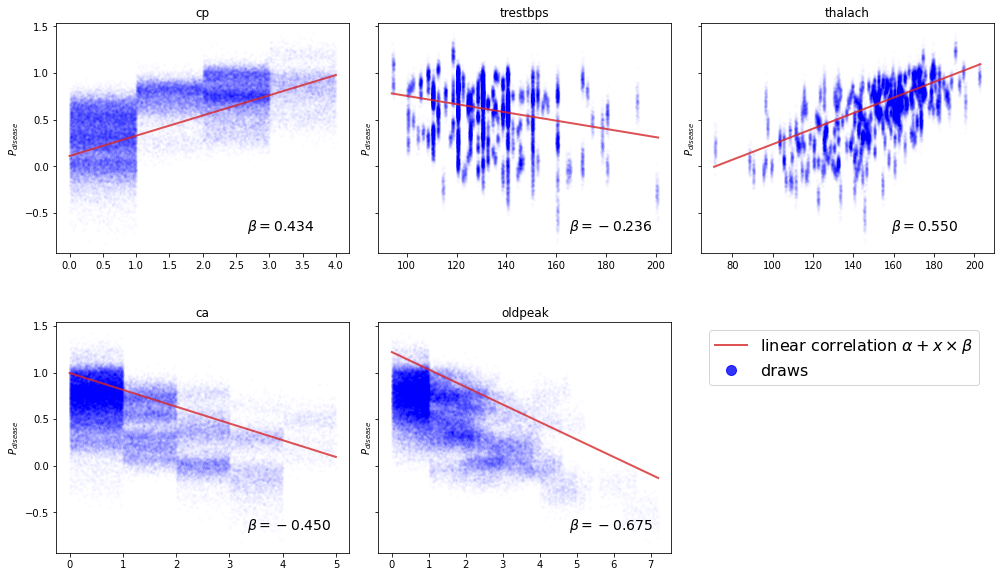

In [3]:
lin.plot_draws(linear_fit, samples)

#### 3.1.4 Convergence diagnostics

In [5]:
import diagnostics

diagnostics.convergence(linear_fit, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,ess_bulk,r_hat
alpha,0.353,0.105,0.191,0.530,0.003,1179.795,1.001
beta[0],0.434,0.067,0.324,0.545,0.002,1900.989,1.002
beta[1],-0.236,0.135,-0.462,-0.016,0.003,1584.375,1.000
beta[2],0.550,0.142,0.316,0.787,0.004,1308.215,1.000
beta[3],-0.450,0.090,-0.597,-0.301,0.002,1635.060,1.002
beta[4],-0.675,0.128,-0.899,-0.480,0.003,1813.557,1.002
sigma,0.384,0.016,0.355,0.408,0.000,2402.306,1.001


,max_tree_depth,mean_tree_depth,divergences_num
stat,6,4.6455,0


As shown in the above tables

- All the parameters's $\hat{R}$ value is close to 1; therefore, the generated chains have been converged well.

- The posterior distribution of the parameters are poor, if the ESS value is small. Hence, the bigger the ESS value the better. In our case, all the parameters' ESS value are more than 1000, this indicates that the models will have stable estimations for most cases.

- There is no chain that diverges so this indicates that the model is good and can be used for further prediction.

- The mean_tree_depth is 4.6 and max tree_depth is 6 also a good model indication.


#### 3.2.5. Posterior predictive checks and what was done to improve the model

In [5]:
%%capture --no-display
diagnostics.k_fold_cv(lin.build, lin.get_disease_prob, samples, outcomes, 5)

241

**5-fold cross validation result:** ETA: 09:54:52 | LOO score: 79.54% | Predicted: 241 / 303 | False positives: 43 | False negatives: 19
Total time: 5.01717472076416

As can be seen, the linear model is not able to properly describe the data and give reliable estimates. It has low predictive accuracy a bit higher than 80% and produces especially high number of false positives diagnoses.

One way of improving the model could be changing its sensitivity threshold, but in best case scenario it improved the model accuracy just by a couple percents, likely just by chance. This approach is far from perfect and doesn't fix false positive predictions' error.

Hence, the linear regression is not recommended to use in real applications, but it can reveal basic insights on the underlying correlations.

/home/susan/.local/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 by 303 log-likelihood matrix

         Estimate       SE
elpd_loo -147240.02  4112.93
p_loo    64424.20        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  303  100.0%

Mean Pareto K: 14.46


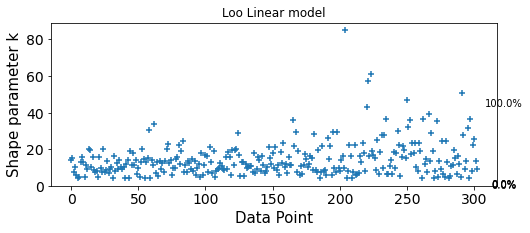

In [12]:
diagnostics.psis_loo_summary(linear_fit, 'Linear')

As can be seen above, the PSIS-LOO doesn't provide reliable estimate due to a large number of Pareto-K values higher than 1 (mean K value is about 3 times higher). Due to that fact can need run K-Fold validation to get more reliable predictive accuracy estimates and provide some intuition about an actual predictive accuracy.

The source code of `k_fold_cv` function can be found in  [Appendix B](#Appendix-B).


#### 3.2.6. Sensitivity analysis with respect to the prior choices

For the prior sensitivity analysis we will use a bit more simple and much quicker version of leave-one-out validation and check within-sample predictive accuracy. This summary is quick and easy to understand but is in general an overestimate of LOO-CV because it is evaluated on the data from which the model was fit.

The PSIS-LOO values are also included in the analysis to build more solid connection between posterior log likelihood values and predictive accuracy.

For the `loo_within_sample` implementation see [Appendix C](#Appendix-C).

In [5]:
%%capture --no-display

from linear_regression_sensitivity import test_priors

summary = test_priors()

In [6]:
display(summary)

,within sample accuracy,k-fold accuracy,PSIS LOO ELPD
"double_exponential(0, 1)",84.49%,82.84%,-197364.427165
"uniform($-\inf$, $\inf$)",84.49%,83.83%,-201101.142785
"normal(0, 1)",84.49%,81.52%,-199374.633079
"normal(0, 10)",84.49%,82.84%,-200139.294774
"normal(0, 100)",84.16%,82.18%,-201158.146481


As shown in the table above, when we change the beta's prior to be drawn from multiple different distributions, the accuracy and the PSIS LOO value of the model does not change significantly or stay more or less the same. Therefore, we can conclude that **our linear regression model is not sensitive to the choice of prior.**


### 3.2 Logistic regression model

#### 3.2.1. Model theoratical/mathematic description

The multivariable logistic regression model describes the relation of given parameters to the probability of detecting disease:
$$ Y_i|X_i \sim Bernoulli(expit(\alpha + \beta_1  x_{1i} + ... + \beta_J x_{Ji}))$$ 
$$ Log Odds(Y=1|X) = log\bigg(\frac{\theta_i}{1-\theta_i}\bigg) = \alpha + \alpha + \beta_1  x_{1i} + ... + \beta_J x_{Ji}$$
$$ i = 1..N$$
where

• $\theta_i$ is the probability of detecting disease\
• $\alpha$ and $\beta_k$ is the parameters of the logistic regression model\
• J is the number of features and N is the number of data points

#### 3.2.2. Priors choice explanation

Although the heart disease dataset was published long time ago, there is still limited amount of medical research using it and the researches study about the relation between the parameters such  ST depression induced by exercise relative to rest or maximum heart rate achieve to the heart disease status. Therefore, we think using the previous knowledge from other heart disease cases is almost imposible for use, instead we used weakly informative priors. We have tried out different priors options and checked out the accuracy of the model. At the end, we decided to choose student distribution _ student_t(2,0,10) as a default prior for alpha and normal distribution _ normal(0, 10) as the default prior for beta.

#### 3.2.3. Model stan code

Below is the stan code for logistic regression model

In [ ]:
logistic_regression = '''
data {
    int<lower=1> N;                                     // number of data points
    int<lower=1> J;                                     // number of dimensions
    matrix[N, J] X;                                     // model input data    
    int<lower=0, upper=1> y[N];                         // outcomes
}

parameters {
    real alpha;        // intercept
    vector[J] beta;    // regression coefficient
}

model {
    // Prior
    alpha ~ student_t(2, 0, 10);
    beta ~ normal(0, 1);

    // Likelihood / distribution of y
    y ~ bernoulli_logit(alpha + X * beta);
}
generated quantities {     
    real<lower=0, upper=1> probs[N];    
    vector[N] log_lik = rep_vector(0, N);    
    real tmp;

    // Calculate LOO
    for (i in 1:N)
    {
        tmp = 0;
        for (j in 1:J)
        {
            tmp += beta[j] * X[i,j];
        }                
        log_lik[i] = bernoulli_logit_lpmf(y|alpha + tmp);
        probs[i] = inv_logit(alpha + tmp); // model
    }         
}
'''

In [7]:
%%capture --no-display

import logistic_regression as logi

nest_asyncio.apply()
model = logi.build(samples, outcomes)
logi_fit = logi.sample(model)

#### 3.2.4. Convergence diagnostics


In [8]:
diagnostics.convergence(logi_fit, var_names=['alpha', 'beta'])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,ess_bulk,r_hat
alpha,-0.516,1.632,-3.166,2.212,0.048,1132.510,1.003
beta[0],0.934,0.166,0.664,1.206,0.005,1069.370,1.001
beta[1],-0.020,0.009,-0.034,-0.003,0.000,1623.933,1.002
beta[2],0.025,0.008,0.013,0.038,0.000,1908.708,1.000
beta[3],-0.772,0.165,-1.039,-0.506,0.004,1442.099,1.002
beta[4],-0.837,0.165,-1.084,-0.545,0.004,1490.827,1.001


,max_tree_depth,mean_tree_depth,divergences_num
stat,7,5.775,0


As shown in the above tables

- All the parameters's $\hat{R}$ value is close to 1; therefore, the generated chains have been converged well.

- The posterior distribution of the parameters are poor, if the ESS value is small. Hence, the bigger the ESS value the better. In our case, all the parameters' ESS value are more than 1000, this indicates that the models will have stable estimations for most cases.

- There is no chain that diverges so this indicates that the model is good and can be used for further prediction.

- The mean_tree_depth is 5.8 and max tree_depth is 7 also a good model indication.


/home/susan/.local/lib/python3.8/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 2000 by 303 log-likelihood matrix

         Estimate       SE
elpd_loo -153142.70  4336.23
p_loo    74951.98        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  303  100.0%

Mean Pareto K: 17.84


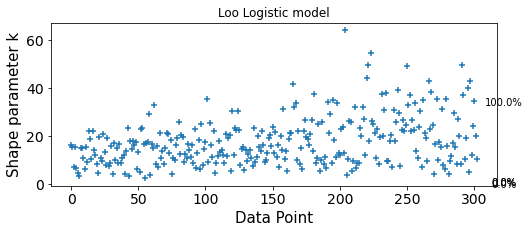

In [14]:
diagnostics.psis_loo_summary(logi_fit, 'Logistic')

As can be seen above, the PSIS-LOO doesn't provide reliable estimate due to a large number of Pareto-K values higher than 1 (mean K value is about 3 times higher). Due to that fact can need run K-Fold validation to get more reliable predictive accuracy estimates and provide some intuition about an actual predictive accuracy.

The source code of `k_fold_cv` function can be found in  [Appendix B](#Appendix-B).

#### 3.2.5. Posterior predictive checks and what was done to improve the model

In [ ]:
diagnostics.k_fold_cv(logi.build_for_accuracy_check, logi.get_disease_prob, samples, outcomes, 5)

#### 3.2.6. Sensitivity analysis with respect to the prior choices
For the sensitivity check we have tried to build the model with different options for beta distribution such as uniform, normal and double exponential (Laplace) distribution. We want check that will output models (alpha and betas) are significantly changed when we vary the beta prior.
By default the **alpha** is always drawn from **student_t(2, 0, 10)** distribution. The only exception is when the beta is drawn from uniform(-inf, inf), we also need to draw alpha from the same distribution (uniform(-inf, inf)); otherwise, the model build will be failed with any other different distribution for alpha.


| beta distribution | uniform(-inf, inf) | normal(0,1) | normal(0,10) | normal(0,100) | double_exponential(0,1) |
| --- | --- | --- |--- | --- |--- |
| alpha| -0.258 |-0.233  |-0.255  |-0.252  |-0.288|
| beta[0]| 0.964 |0.930  |0.971  |0.959  |0.922|
| beta[1]| -0.348 |-0.330  |-0.352  |-0.341  |-0.310|
| beta[2]| 0.576 |0.566  |0.571  |0.571  |0.579|
| beta[3]| -0.795 |-0.768  |-0.801  |-0.791  |-0.764|
| beta[4]| -0.998 |-0.963  |-1.004|-1.012  |-0.972|

As shown in the table above, when we change the beta's prior to be drawn from multiple different distributions, the output model does not changed much, the alpha's and betas' number stay more or less the same. Therefore, we can conclude that **our logistic regression model is not sensitive to the choice of prior.**

## 4. MODEL COMPARSION<a class="anchor" id="4"></a>

In [4]:
%%capture --no-display

from model_comparison import compare_models

comparison = compare_models()

In [5]:
display(comparison[['loo', 'se', 'd_loo', 'k-fold accuracy']])


,loo,se,d_loo,k-fold accuracy
linear_model,-146634.728689,4228.561029,0.000000,0.792079
logistic_model,-149356.339335,4224.762999,2721.610646,0.788779


Based on estimated predictive accuracy and provided analysis of the LOO value we conclude that the **linear** regression model shows slightly **better** performance than the **logistic** regression model.

## 5. PREDICTIVE PERFORMANCE ASSESSMENT<a class="anchor" id="5"></a>
TODO:
(e.g. classification accuracy) and evaluation of practical usefulness of the accuracy. If not applicable, then explanation why in this case the predictive performance is not applicable.

## 6. DISCUSSION ISSUES AND POTENTIAL IMPROVEMENTS<a class="anchor" id="6"></a>
- The linear and logistic regression models are one of the simpliest models that can be use to predict data. Using over simplify models exposes the thread that the model will fail to precisely predict the data. In future, we want to conduct more experiment with more different kind and complicated model such as hierarchical models.
- The limitation of the dataset also causes

## 7. CONCLUSION<a class="anchor" id="7"></a>
We were interested in building the Bayesian statistical model to predict heart diseases based on easy to measure parameters.

The linear and logistic models provided us with similar accuracy and estimates, regardless of the priors we choose. Although the linear model showed slightly better results both in terms of accuracy, estimated by K-fold validation and in terms of ELPD values from PSIS LOO. The $\beta$ parameter values they infer are in line with our medical background knowledge and seems rather reasonable in each case. 

## 8. SELF-REFLECTION LESSONS<a class="anchor" id="8"></a>
TODO: What group learn during project


### Appendix A

**Dataset parameters explanation**
1. age
2. sex: 0: female, 1: male
3. cp: chest pain type (4 values) 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
4. trestbps: resting blood pressure
5. chol: serum cholestoral in mg/dl
6. fbs: fasting blood sugar > 120 mg/dl (1 = True, 0 = False)
7. restecg: resting electrocardiographic results (values 0 = normal, 1 = having ST-T wave abnormality, 2 = showing proable or definite left ventricular hypertrophy by Estes's criteria)
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment
12. ca: number of major vessels (0-4) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
14. target: angiographic disease status (0 = <50% diameter narrowing _ no presence, 1% = >50% diameter narrowing _ presence)

In [ ]:
with open('linear_regression.stan', 'r') as file:
    display_markdown(f"```cpp\n{file.read()}\n```", raw=True)


### Appendix B

**K-Fold validation**

This function implements the K-Fold validation by fitting the model with n/k elements excluded from the data. Then estimated disease probability is then compared with actual `target` value for the given test sample.

In [ ]:
display_markdown(f"```python\n{inspect.getsource(diagnostics.k_fold_cv)}\n```", raw=True)

### Appendix C

**Leave-one-out within-sample predictive accuracy**

This function relies on `probs` values computed by Stan model's `generated quantities` block.

In [ ]:
display_markdown(f"```python\n{inspect.getsource(lin.loo_within_sample)}\n```", raw=True)